**Interpretatable Machine Learning**

*Welcome to Machine Learning Housing Corp.! Your task is to interpret the outcome of a random forests model trained on the California Housing dataset.*


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup
This first part of the notebook is copied from Chapter 2 of Hands-on Machine learning to prep and clean the dataset

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

In [5]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
  

In [6]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]



In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

housing_num = housing.drop("ocean_proximity", axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)


#### Here we make sure the feature names are seperated for numeric and categorical features, so our plotting is prettier later on.

In [9]:
categorical_features=[8]
ohe_categories = full_pipeline.named_transformers_["cat"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_attribs, ohe_categories) for val in vals]
all_features = num_attribs+["rooms_per_household", "population_per_household",'bedrooms_per_room'] + new_ohe_features
housing_prepared=pd.DataFrame(
    housing_prepared,
    columns=all_features,
    index=housing.index)

# Model Training
Next we train a random forest model on the dataset, where we tune hyperparameters and select the best model using grid search.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30,40,50], 'max_features': [2, 4, 6, 8,10]},
 ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [3, 10, 30, 40, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [11]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 50}

#### We found the best model. We fit it to the training data and call the model `est`


In [12]:
forest_reg = RandomForestRegressor(max_features= 8, n_estimators=50, random_state=42)
est=forest_reg.fit(housing_prepared, housing_labels)

#### Apply the model to the test data

In [159]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared=pd.DataFrame(
    X_test_prepared,
    columns=all_features,
    index=X_test.index)

final_predictions = final_model.predict(X_test_prepared)



# Methods for model interpretation
## Feature importance
We can inspect the impurity-based feature importances from tree based methods like random forest

In [148]:
est.feature_importances_

array([7.07771053e-02, 6.41234817e-02, 4.30905372e-02, 1.48114863e-02,
       1.44659040e-02, 1.49347989e-02, 1.40999632e-02, 3.81445119e-01,
       5.17980839e-02, 1.10770738e-01, 5.16206540e-02, 9.13723773e-03,
       1.53943103e-01, 7.63229721e-05, 1.98963174e-03, 2.91583249e-03])

Plot the feature importance plot to compare them.

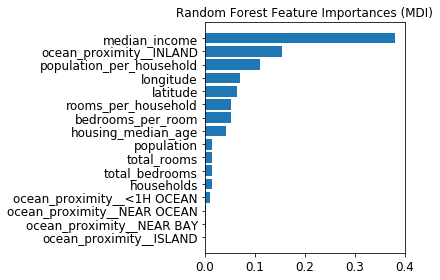

In [149]:
tree_feature_importances = est.feature_importances_
sorted_idx = tree_feature_importances.argsort()
all_features
sorted_idx
list( np.array(all_features, dtype=object)[sorted_idx] )
y_ticks = np.arange(0, len(all_features))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(list( np.array(all_features, dtype=object)[sorted_idx] ))
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Next we add error bars based on the importance from each tree in the forest.

Text(0, 0.5, 'Mean decrease in impurity')

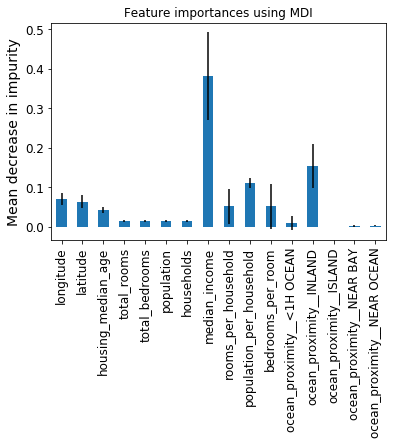

In [154]:
importances = forest_reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_reg.estimators_], axis=0)


forest_importances = pd.Series(importances, index=all_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

## Permutation Feature Importance

- The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.
- This is especially useful for non-linear or opaque estimators. 
- The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled 
- This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. 
- This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.
- Should we evaluate on training or test set?
  - How much does the model rely on each feature for making predictions (-> training data)
  - How much does the feature contribute to the performance of the model on unseen data (-> test data)


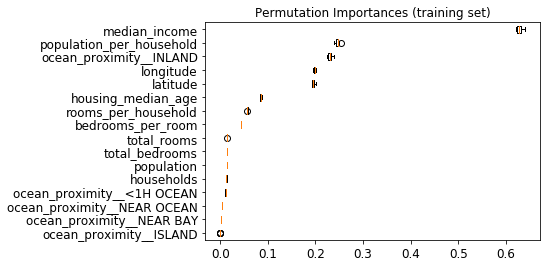

In [163]:
from sklearn.inspection import permutation_importance
result = permutation_importance(forest_reg, housing_prepared, housing_labels, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=housing_prepared.columns[sorted_idx])
ax.set_title("Permutation Importances (training set)")
plt.show()

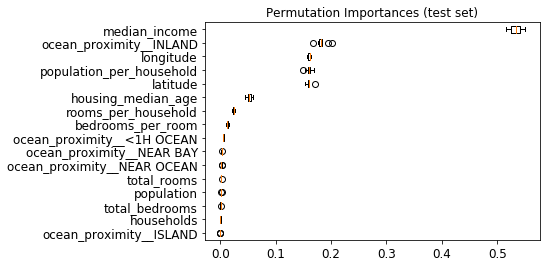

In [164]:
from sklearn.inspection import permutation_importance
result = permutation_importance(forest_reg, X_test_prepared, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test_prepared.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

## Partial Dependence Plots (PDP)
- Visualize and analyze interaction between the target response and a set of input features of interest
- Assume that the input features of interest are independent from the complement features (often violated in practice)
- Interpret the partial dependence as the expected target response as a function of the input features of interest

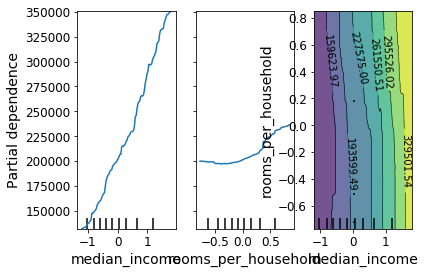

In [167]:
from sklearn.inspection import plot_partial_dependence
disp1 = plot_partial_dependence(est, housing_prepared,[7, 8,(7,8)])  

## Individual Conditional Expectation - ICE
- Show the dependence between the target function and an input feature of interest
- Visualize the dependence of the prediction on a feature for each sample separately with one line per sample
- Due to the limits of human perception, only one input feature of interest is supported for ICE plots
- When interactions are present the ICE plot can provide more insights

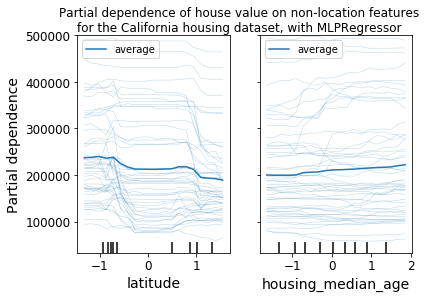

In [168]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
display = plot_partial_dependence(
       est, housing_prepared, [1,2], subsample=50,kind='both',
       n_jobs=1, grid_resolution=20, random_state=0
)

display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with MLPRegressor'
)
display.figure_.subplots_adjust(hspace=0.3)

## Local Interpretable Model-agnostic Explanations - LIME
- Used to explain individual predictions of black box machine learning models
- Goal: understand why the machine learning model made a certain prediction
- LIME tests what happens to the predictions when you give variations of your data into the machine learning model
  1. Select instance of interest for which to have an explanation of the black box prediction
  2. Perturb the dataset and get the black box predictions for these new points
  3. Weight the new samples according to their proximity to the instance of interest
  4. Train a weighted, interpretable model on the dataset with the variations
  5. Explain the prediction by interpreting the local model


In [169]:
import lime
from lime import lime_tabular

In [170]:
explainer_lime = lime_tabular.LimeTabularExplainer(np.array(housing_prepared),
                                 mode="regression",
                                 feature_names=all_features,
                                 categorical_names=new_ohe_features,
                                 categorical_features=categorical_features,
                                 random_state=42)

In [171]:
np.random.seed(1)
i = 100
exp_lime = explainer_lime.explain_instance(np.array(X_test_prepared)[i], predict_fn=final_model.predict, num_features=5)
exp_lime.show_in_notebook(show_all=False)

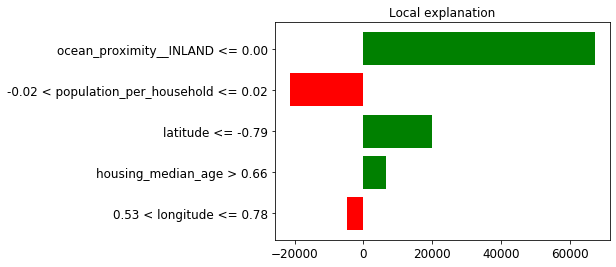

In [172]:
%matplotlib inline
fig = exp_lime.as_pyplot_figure()

## SHAP
The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. 
- The SHAP explanation method computes Shapley values from coalitional game theory
- Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features 
  - A player can be an individual feature value, e.g. for tabular data 
  - A player can be a group of feature values. For example to explain an image, pixels can be grouped to super pixels and the prediction distributed among them


In [182]:
### SHAP
import shap
# This takes a while to run
explainer = shap.Explainer(est)
shap_values = explainer.shap_values(housing_prepared, approximate=False, check_additivity=False)

### Beeswarm
- Overview of which features are most important for a model 
- Show every feature for every sample
- Uses SHAP values to show the distribution of the impacts each feature has on the model output
- The color represents the feature value (red high, blue low)

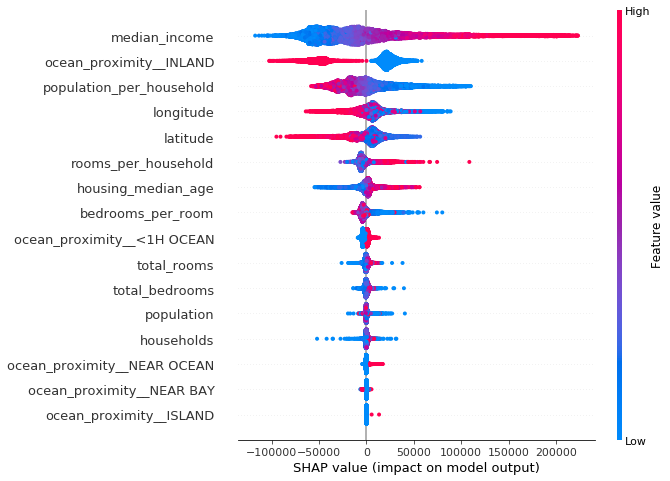

In [183]:
shap.summary_plot(shap_values,housing_prepared)

Another version of beeswarms

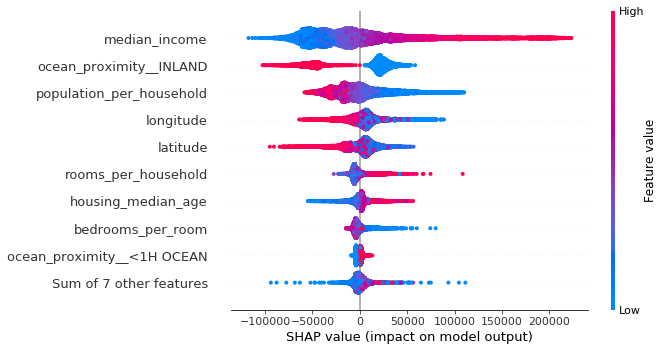

In [198]:
shap.initjs()
shap_obj=explainer(housing_prepared) # This takes a while to run
shap.plots.beeswarm(shap_obj) 

### Waterfall
- This visualization shows how each feature contributes to push the model output from the base value (the average model output over the training dataset we passed) to the model output 
- Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue
- Used to inspect a single instance.

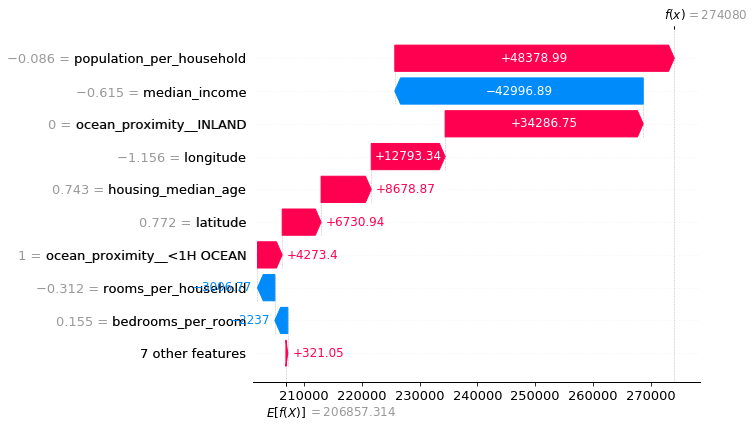

In [185]:
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0],housing_prepared.iloc[0])

## Force - single instance
The force plot shows the same as the waterfall plot, but aligns the bars in a single row, stacking them.

In [186]:
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0],housing_prepared.iloc[0])

## Force - All observations
To see explanations for an entire dataset: take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally.
The plot is interactive
- x axis: Change the ordering of the observations
- y axis: Overall SHAP values or by variable


In [187]:
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[1:1000],housing_prepared.iloc[1:1000])

## Dependence plot
The dependence  plot shows the SHAP value of a gvien feature vs. the value of the feature for all the examples in a dataset. Allows us to understand how a single feature effects the output of the model.
Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in predicted value as the feature changes. Vertical dispersion at a single value of the feature represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. 

- Scatter plot that shows the effect a single feature has on the predictions made by the model.
- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix).
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.
- The color corresponds to a second feature that may have an interaction effect with the feature we are plotting (by default this second feature is chosen automatically). If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. 


1. Dependence plot of a single feature

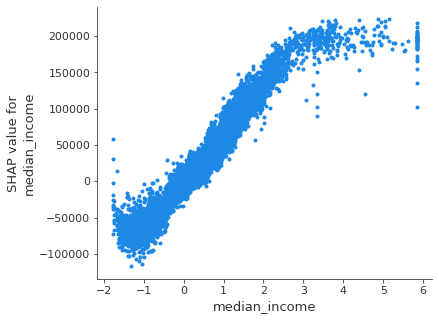

In [188]:
shap.dependence_plot("median_income", shap_values, housing_prepared, interaction_index=None)

2. Dependence plot with an interaction effect - shown by coloring the nodes according to the values of another feature.

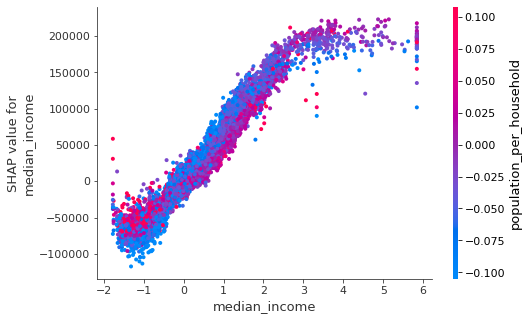

In [189]:
shap.dependence_plot("median_income", shap_values, housing_prepared)

The plot above can be made with each of the following commands

In [ ]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(7, shap_values, housing_prepared)
# If we pass a numpy array instead of a data frame then we
# need pass the feature names in separately
shap.dependence_plot(7, shap_values, housing_prepared.values, feature_names=X.columns)
# We can pass a feature name instead of an index
shap.dependence_plot("median_income", shap_values, housing_prepared)
# We can also use the special "rank(i)" systax to specify the i'th most
# important feature to the model. As measured by: np.abs(shap_values).mean(0)
# In this example age is the second most important feature.
shap.dependence_plot("rank(1)", shap_values, housing_prepared)
# The interaction_index argument can be used to explicitly
# set which feature gets used for coloring
shap.dependence_plot("rank(1)", shap_values, housing_prepared, interaction_index="population_per_household")

3. Use `shap.approximate_interactios` to guess which features may interact with the feature. Make plots colored by each of the top three possible interacting features

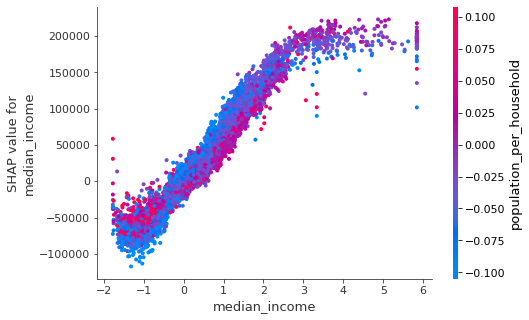

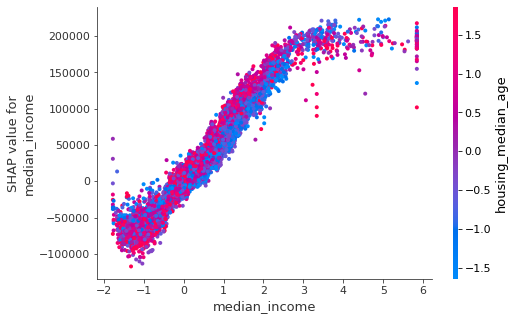

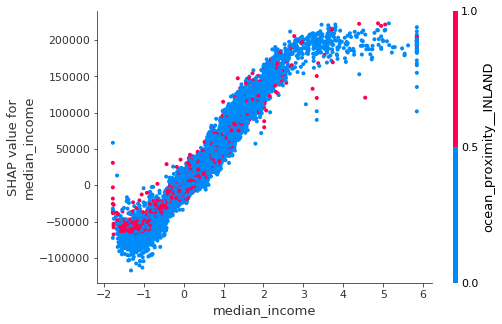

In [190]:
inds = shap.approximate_interactions("median_income", shap_values, housing_prepared)

for i in range(3):
    shap.dependence_plot("median_income", shap_values, housing_prepared, interaction_index=inds[i])

## Barplot
We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot


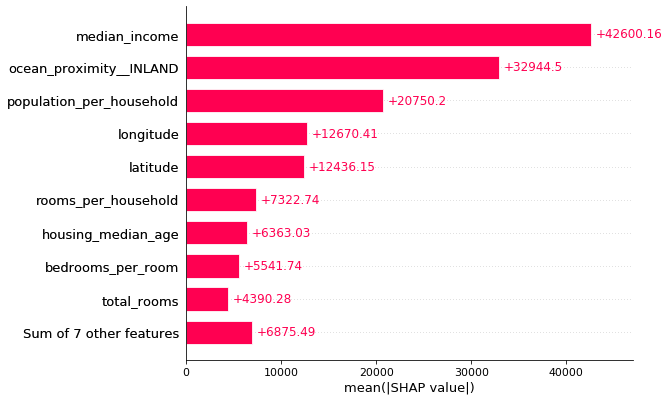

In [25]:
shap.plots.bar(shap_values)